<a href="https://colab.research.google.com/github/priyadarshpv/DeepFake-Detector/blob/main/DeepFake_Detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

In [3]:
!kaggle datasets download -d "manjilkarki/deepfake-and-real-images"

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.68G/1.68G [00:17<00:00, 131MB/s]
100% 1.68G/1.68G [00:17<00:00, 101MB/s]


In [4]:
!unzip "/content/deepfake-and-real-images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [9]:
real_images = len(os.listdir("/content/Dataset/Train/Real"))
fake_images = len(os.listdir("/content/Dataset/Train/Fake"))

print(f"Real images: {real_images}")
print(f"Fake images: {fake_images}")

Real images: 70001
Fake images: 70001


In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [5]:
img_size = (224, 224)
batch_size = 32

# Data preprocessing (normalization)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "/content/Dataset/Train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",  # Binary classification (Fake vs Real)
    shuffle=True
)


val_generator = datagen.flow_from_directory(
    "/content/Dataset/Validation",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


test_generator = datagen.flow_from_directory(
    "/content/Dataset/Test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)

{'Fake': 0, 'Real': 1}


In [15]:
# Load Xception
base_model = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(1, activation="sigmoid")(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-5),loss="binary_crossentropy",metrics=["accuracy"])

model.summary()

history = model.fit(train_generator,epochs=10,validation_data=val_generator)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,387,305 (81.59 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 20,861,992 (79.58 MB)

Epoch 1/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 740s 166ms/step - accuracy: 0.6318 - loss: 0.7607 - val_accuracy: 0.7463 - val_loss: 0.5281
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 720s 164ms/step - accuracy: 0.7168 - loss: 0.6036 - val_accuracy: 0.7551 - val_loss: 0.5083
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 720s 165ms/step - accuracy: 0.7331 - loss: 0.5608 - val_accuracy: 0.7671 - val_loss: 0.4897
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 720s 165ms/step - accuracy: 0.7441 - loss: 0.5356 - val_accuracy: 0.7668 - val_loss: 0.4875
Epoch 5/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 721s 165ms/step - accuracy: 0.7517 - loss: 0.5181 - val_accuracy: 0.7697 - val_loss: 0.4824
Epoch 6/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 767s 175ms/step - accuracy: 0.7565 - loss: 0.5059 - val_accuracy: 0.7714 - val_loss: 0.4765
Epoch 7/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 720s 164ms/step - accuracy: 0.7664 - loss: 0.4891 - val_accuracy: 0.7769 - val_loss: 0.4706
Epoch 8/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 721s 165ms/step - ac

In [6]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 2516s 7s/step - accuracy: 0.7622 - loss: 0.4899
Test accuracy: 71.87%


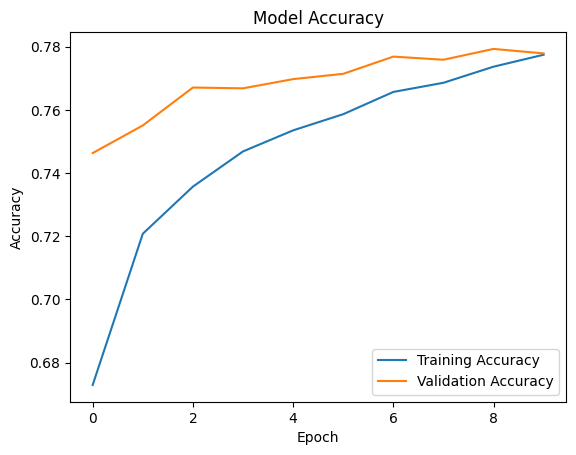

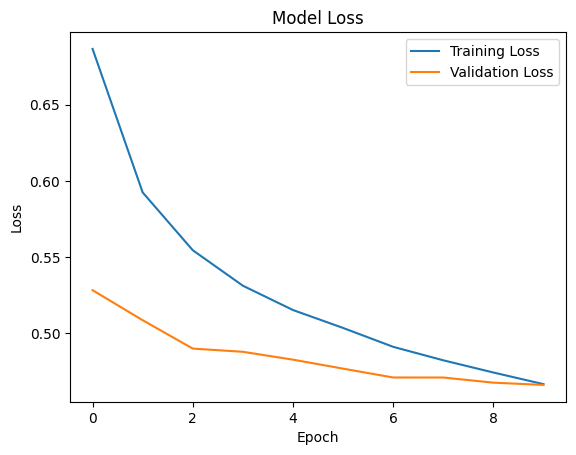

In [16]:
#Model accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Model loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
model.save("xception_deepfake_detection_model.h5")